# 필요 라이브러리

In [2]:
import torch
import torchvision
from torchvision import tv_tensors
from tqdm.auto import tqdm
from warnings import filterwarnings
from matplotlib import font_manager, rc
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.transforms import v2
filterwarnings('ignore')
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=12) 


c:\Users\hyssk\anaconda3\envs\objectdetection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Custom Dataset 구성

In [3]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from pathlib import Path
from torchvision.utils import draw_bounding_boxes
from json import load
import torch
import matplotlib.pyplot as plt

In [4]:
classes=['c_1','c_2_01','c_2_02','c_3',
         'c_4_01_02','c_4_02_01_02',
         'c_4_02_02_02','c_4_02_03_02','c_4_03','c_5_02',
         'c_6','c_7','c_1_01','c_2_02_01',
         'c_3_01','c_4_03_01','c_5_01_01',
         'c_5_02_01','c_6_01','c_7_01',
         'c_4_01_01','c_4_02_01_01',
         'c_4_02_02_01','c_4_02_03_01',
         'c_5_01','c_8_01','c_8_02',
         'c_8_01_01','c_9']

In [5]:
train_transform = v2.Compose([
    v2.RandomRotation(90),
    v2.ToTensor()
])

In [13]:
# TrashDataset에서 불러와야할 것들
'''전처리한 화상의 텐서 형식 데이터와 어노테이션 획득'''
'''전터리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''
train_anno_path = Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Training\02.라벨링데이터')
train_img_dir = Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Training\01.원천데이터')

test_img_dir= Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Validation\01.원천데이터')
test_anno_path= Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Validation\02.라벨링데이터')

# Trash Dataset에서 뭘 뽑아내야할까
# Image의 [3 channels, width, height] 에 대한 정보, 해당 이미지의 Annotation 정보 (class 정보, BBOX)
class TrashDataset(Dataset):
    def __init__(self, classes, anno_path, img_dir, transform = None):
        self.anno_list = sorted(list(anno_path.glob('*.json'))) # annotation 파일들 모으고 sorted로 정렬
        self.img_list = sorted(list(img_dir.glob('*.jpg'))) # image 파일들을 모으고 sorted로 정렬
        self.transform= transform
        self.classes = classes

    def __getitem__(self, idx):
        # img 읽어오기
        img = read_image(str(self.img_list[idx]))

        # img와 맞는 annotation_path
        annotation_path = self.anno_list[idx]

        #  ret : [[xmin,ymin,xmax,ymax,label_ind],...]
        ret=[]
        with open(annotation_path, 'r') as f:
            data = load(f)
            for object in data['objects']:
                bndbox=[]
                for coord in object["annotation"]['coord']: # [X,Y,Width,Height] -> [X,Y,Xmax,Ymax] 변환
                    if coord == 'x':
                        bndbox.append(int(object['annotation']['coord'][coord])) # / float(data['Info']['RESOLUTION'].split('/')[0]))
                    elif coord =='y':
                        bndbox.append(int(object['annotation']['coord'][coord])) # / float(data['Info']['RESOLUTION'].split('/')[1]))
                    elif coord == 'width':
                        bndbox.append(int(object['annotation']['coord']['x'] + object['annotation']['coord'][coord])) # / float(data['Info']['RESOLUTION'].split('/')[0]))
                    elif coord == 'height':
                        bndbox.append(int(object['annotation']['coord']['y'] + object['annotation']['coord'][coord])) # / float(data['Info']['RESOLUTION'].split('/')[1]))
                bndbox.append(classes.index(object['class_name']))
        # [3 channels, width, height], [[Xmin,Ymin,Xmax,Ymax,label_idx],....] // shape [N,5]
                width,height = data['Info']['RESOLUTION'].split('/')
                ret.append(bndbox)
        coord = [row[:-1] for row in ret]
        boxes = tv_tensors.BoundingBoxes(coord,format="XYXY",canvas_size=(int(height),int(width)))
        transformed_img, transformed_boxes = self.transform(torch.tensor(img),boxes)
        class_idx = [row[-1] for row in ret]
        return transformed_img.to('cuda'), transformed_boxes, class_idx
    def __len__(self):
        return len(self.anno_list)

train_dataset = TrashDataset(classes=classes,anno_path= train_anno_path,img_dir = train_img_dir,transform=train_transform)
train_dataset[0]

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8),
 BoundingBoxes([[ 11, 405, 445, 883],
                [503, 260, 949, 737],
                [748,   0, 991, 142]], format=BoundingBoxFormat.XYXY, canvas_size=(883, 1847)),
 [3, 3, 3])

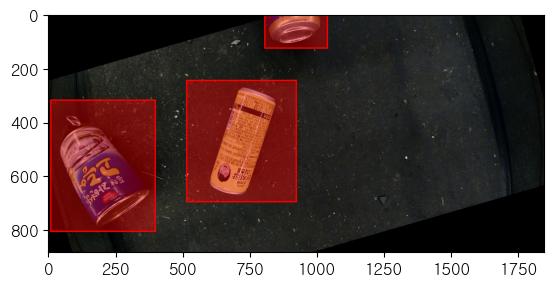

In [27]:
img,boxes,class_idx = train_dataset[0]
drawn_box = draw_bounding_boxes(img, boxes, labels=[classes[i] for i in class_idx], colors=(255,0,0),width=5,font_size=10,fill=True)
plt.figure()
plt.imshow(drawn_box.permute(1,2,0))
plt.show()